# Basic rpy2 functionality, and Johansen Cointegration test

### Import modules

In [1]:
%matplotlib inline
import rpy2
print(rpy2.__version__)

2.8.6


In [2]:
# Turn off warnings for a cleaner look
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import R package for Johansen cointegration test
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
urca = importr('urca')

# Import other modules
from rpy2.robjects import FloatVector, ListVector

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

quantmod = importr('quantmod')   # getSymbols
base = importr('base')

In [4]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

### Pull Data

In [5]:
start = datetime.datetime.strftime(datetime.datetime(2006, 4, 26), '%Y-%m-%d')
end = datetime.datetime.strftime(datetime.datetime(2012, 4, 9), '%Y-%m-%d')

# This is a convoluted way of pulling price data.  The point is to show how the
# getSymbols function in R's quantmod library can be called.  It is a bit unconventional.
base.do_call('getSymbols', ListVector({'Symbols': "EWA", 'from': start, 'to': end}))
base.do_call('getSymbols', ListVector({'Symbols': "EWC", 'from': start, 'to': end}))
base.do_call('getSymbols', ListVector({'Symbols': "IGE", 'from': start, 'to': end}))

ewa = pd.DataFrame(r['EWA'])
ewc = pd.DataFrame(r['EWC'])
ige = pd.DataFrame(r['IGE'])

col_num = 5

commodities_quantmod = pd.DataFrame({'EWA': ewa.loc[:, col_num], 
                                     'EWC': ewc.loc[:, col_num],
                                     'IGE': ige.loc[:, col_num],})

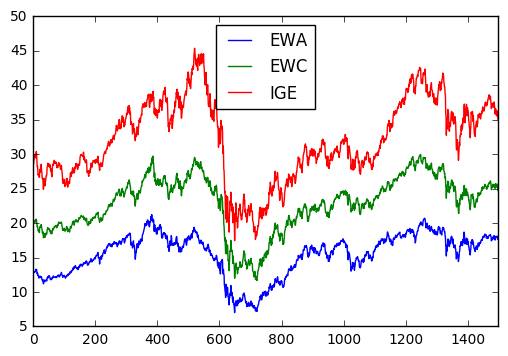

In [6]:
# Dates are missing.  Again, this is not the preferred way of pulling price data.
commodities_quantmod.plot()

### Johansen Co-integration test

In [7]:
""" R version:
jotest=ca.jo(data.frame(p,q,r), type="trace", K=2, ecdet="none", spec="longrun")
summary(jotest)
"""

cajo = urca.ca_jo(commodities_quantmod, type='trace', K=2, ecdet='none', spec='longrun')
summary = urca.summary(cajo)

In [8]:
print(summary)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.011822771 0.008279702 0.002926144

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  4.39  6.50  8.18 11.65
r <= 1 | 16.83 15.66 17.95 23.52
r = 0  | 34.64 28.71 31.52 37.22

Eigenvectors, normalised to first column:
(These are the cointegration relations)

           EWA.l2    EWC.l2    IGE.l2
EWA.l2  1.0000000  1.000000  1.000000
EWC.l2 -1.0780224  3.183354  3.881765
IGE.l2  0.2315914 -2.999329 -1.364231

Weights W:
(This is the loading matrix)

            EWA.l2      EWC.l2       IGE.l2
EWA.d -0.006852267 0.003873787 -0.001102236
EWC.d  0.021833103 0.004142572 -0.001205207
IGE.d  0.028504937 0.010043608 -0.000933173




`summary` is an R object of type `S4`:

In [9]:
list(summary.slotnames())

['classname',
 'test.name',
 'testreg',
 'teststat',
 'cval',
 'bpoint',
 'signif',
 'model',
 'type',
 'auxstat',
 'lag',
 'H',
 'A',
 'lambda',
 'pval',
 'V',
 'W',
 'P']

In [10]:
type(summary)

rpy2.robjects.methods.RS4

The class is `sumurca`:

In [11]:
tuple(summary.rclass)

('sumurca',)

Object attributes are also called slots in R.  Here's a list of `summary`'s slots:

In [12]:
print(list(summary.slotnames()))

# Alternate method
print(list(summary.slots.keys()))

# Alternate method
print(list(summary.list_attrs()))

['classname', 'test.name', 'testreg', 'teststat', 'cval', 'bpoint', 'signif', 'model', 'type', 'auxstat', 'lag', 'H', 'A', 'lambda', 'pval', 'V', 'W', 'P']
['classname', 'test.name', 'testreg', 'teststat', 'cval', 'bpoint', 'signif', 'model', 'type', 'auxstat', 'lag', 'H', 'A', 'lambda', 'pval', 'V', 'W', 'P', 'class']
['classname', 'test.name', 'testreg', 'teststat', 'cval', 'bpoint', 'signif', 'model', 'type', 'auxstat', 'lag', 'H', 'A', 'lambda', 'pval', 'V', 'W', 'P', 'class']


Accessing the attributes via the `rpy2` property `slots` in the manner of Python `dict`:

In [13]:
V = summary.slots['V']

`W` is an `R Matrix` object:

In [14]:
type(V)

rpy2.robjects.vectors.Matrix

In [15]:
np.asarray(V)

array([[ 1.        ,  1.        ,  1.        ],
       [-1.07802242,  3.18335357,  3.88176508],
       [ 0.23159144, -2.99932852, -1.3642311 ]])

Let's see how stationary the linear combination using the 1st eigenvector looks:

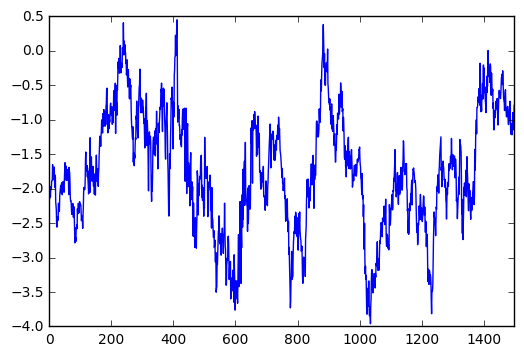

In [16]:
coint_relation = np.asarray(summary.slots['V'])[:, 0]
(commodities_quantmod * coint_relation).sum(axis=1).plot()

### Alternative implemention of Johansen Test

In [17]:
from statsmodels.tsa.stattools import adfuller

# This johansen module is borrowed from the 'coint' branch of:
# https://github.com/josef-pkt/statsmodels
from lib.johansen import coint_johansen

from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt

In [18]:
def get_johansen(y, p):
        """
        From: http://nbviewer.jupyter.org/github/mapsa/seminario-doc-2014/blob/master/cointegration-example.ipynb
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        for i in range(l):
            print('trstat[i]: ' + str(trstat[i]) + ', tsignf[i, 1]: ' + str(tsignf[i, 1]))
            if trstat[i] > tsignf[i, 1]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres

Note that at the 5% level, this version of the Johansen test based off a Pythonized Matlab `jplv7` library shows as significant (t-stat of 4.3868 vs critical value 3.8415), while the `urca` R package shows lack of significance.

In [19]:
jres = get_johansen(np.asarray(commodities_quantmod), 1)

(1498, 3)
(1498, 3)
rkt (1497, 3) (1497, 3)
trstat[i]: 34.6373126301, tsignf[i, 1]: 29.7961
trstat[i]: 16.8331692833, tsignf[i, 1]: 15.4943
trstat[i]: 4.38685881281, tsignf[i, 1]: 3.8415


In [20]:
jres.evecr

array([[ 1.18548837, -0.19077791,  0.09052959],
       [-1.27798305, -0.60731353,  0.35141462],
       [ 0.27454896,  0.57220561, -0.12350329]])

Does this look stationary?

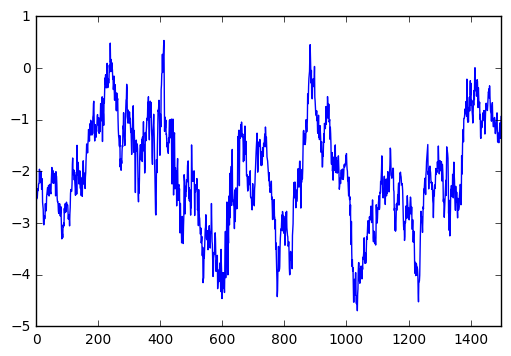

In [21]:
(commodities_quantmod * jres.evecr[:, 0]).sum(axis=1).plot()

What about this?

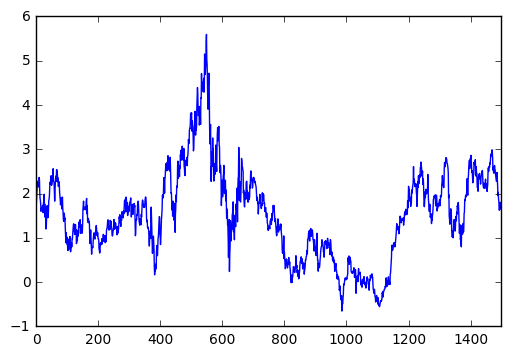

In [22]:
(commodities_quantmod * jres.evecr[:, 1]).sum(axis=1).plot()

And what about this?

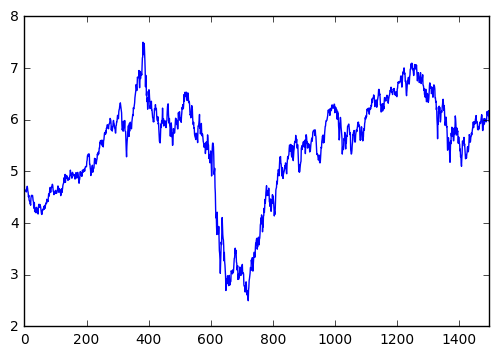

In [23]:
(commodities_quantmod * jres.evecr[:, 2]).sum(axis=1).plot()

### Interesting Links

  - [Testing for cointegration: Johansen vs Dickey-Fuller](http://r.789695.n4.nabble.com/Testing-for-cointegration-Johansen-vs-Dickey-Fuller-td926500.html)

### Scratch work

These few cells are from:
http://nbviewer.jupyter.org/github/mapsa/seminario-doc-2014/blob/master/cointegration-example.ipynb

In [24]:
mu, sigma = 0, 1 # mean and standard deviation
n = 10000
s1 = np.random.normal(mu, sigma, n)
s2 = np.random.normal(mu, sigma, n)
s3 = np.random.normal(mu, sigma, n)

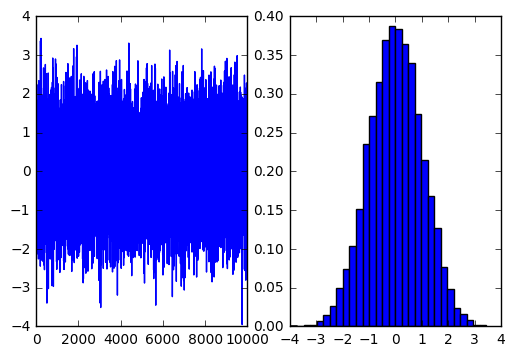

In [25]:
s = s1
plt.figure(1)
plt.subplot(121)
plt.plot(s)
plt.subplot(122)
plt.hist(s, 30, normed=True)
plt.show()

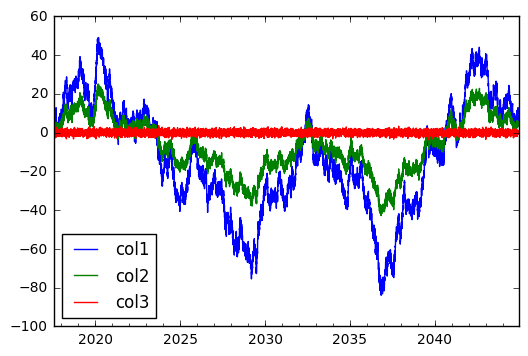

In [26]:
a = 0.5
x_1t = np.cumsum(s1)+s2
x_2t = a*np.cumsum(s1)+s3
x_3t = s3
todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(10), periods=n, freq='D')
y = pd.DataFrame(index=index, data={'col1': x_1t, 'col2': x_2t, 'col3':x_3t} )
y.plot()

In [27]:
p=1
jres=get_johansen(y,p)
print("There are " + str(jres.r) + " cointegration vectors")
v1=jres.evecr[:,0]
v2=jres.evecr[:,1]
print(v1)
print(v2)
v3=jres.evec[:,2]  # v3 is not a cointegration vector


(9999, 3)
(9999, 3)
rkt (9998, 3) (9998, 3)
trstat[i]: 8295.86439534, tsignf[i, 1]: 29.7961
trstat[i]: 4040.09713566, tsignf[i, 1]: 15.4943
trstat[i]: 3.01313288756, tsignf[i, 1]: 3.8415
There are 2 cointegration vectors
[-0.92771329  1.85589644 -0.77057802]
[-1.08699416  2.1735866  -3.10240091]


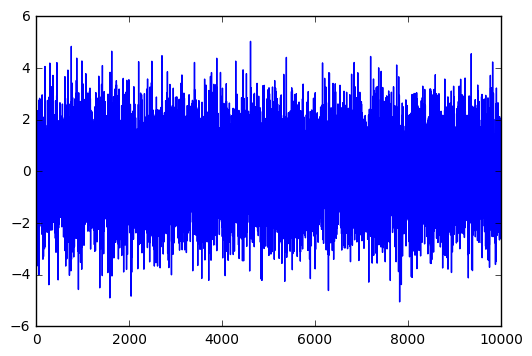

In [28]:
plt.plot(np.dot(y.as_matrix(),v1))

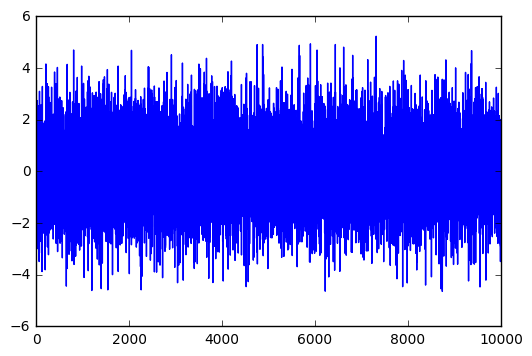

In [29]:
plt.plot(np.dot(y.as_matrix(),v2))

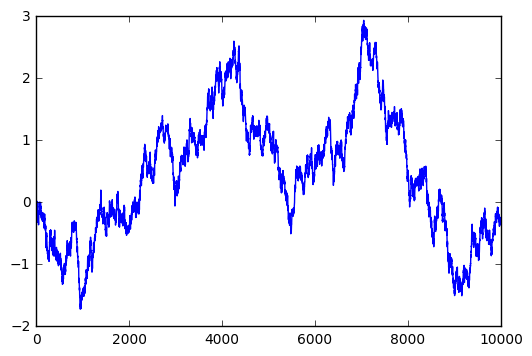

In [30]:
plt.plot(np.dot(y.as_matrix(),v3))

Other ways of pulling price data

In [31]:
# start = datetime.datetime(2014, 12, 1)
# end = datetime.datetime(2017, 7, 1)
# airlines = web.DataReader(['DAL', 'UAL', 'AAL'], 'google', start, end)

# start = datetime.datetime(2006, 4, 26)
# end = datetime.datetime(2012, 4, 9)
# commodities = web.DataReader(['EWA', 'EWC', 'IGE'], 'google', start, end)

# commodities['Close'].plot()

In [32]:
# ewa = FloatVector(commodities['Close']['EWA'].tolist())
# ewc = FloatVector(commodities['Close']['EWC'].tolist())
# ige = FloatVector(commodities['Close']['IGE'].tolist())

In [33]:
# cajo = urca.ca_jo(commodities['Close'], type='trace', K=2, ecdet='none', spec='longrun')
# print(urca.summary(cajo))